\begin{center}
Gabe Morris
\end{center}

In [1]:
# Notebook Preamble
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve, curve_fit
from scipy.interpolate import interp1d
from IPython.display import display, Markdown, Latex

plt.style.use('maroon_ipynb.mplstyle')

\pagebreak
\tableofcontents
\pagebreak

\begin{center}
\begin{tabular}{c c c}
ME 8253 & Homework 3 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

#
## Given
The initial part of the load-displacement curve from the tension test of a 6061-T6 aluminum alloy is shown below. A cylindrical specimen with an initial gage section diameter of 6.3 mm and an initial uniform gage section length of 12.7 mm was used. After fracture, which occurred at a load of 7.2 kN, the minimum diameter in the neck region, $D_{min}$, and the neck radius, $R$, were measured to be 4.2 mm and 3.3 mm, respectfully.

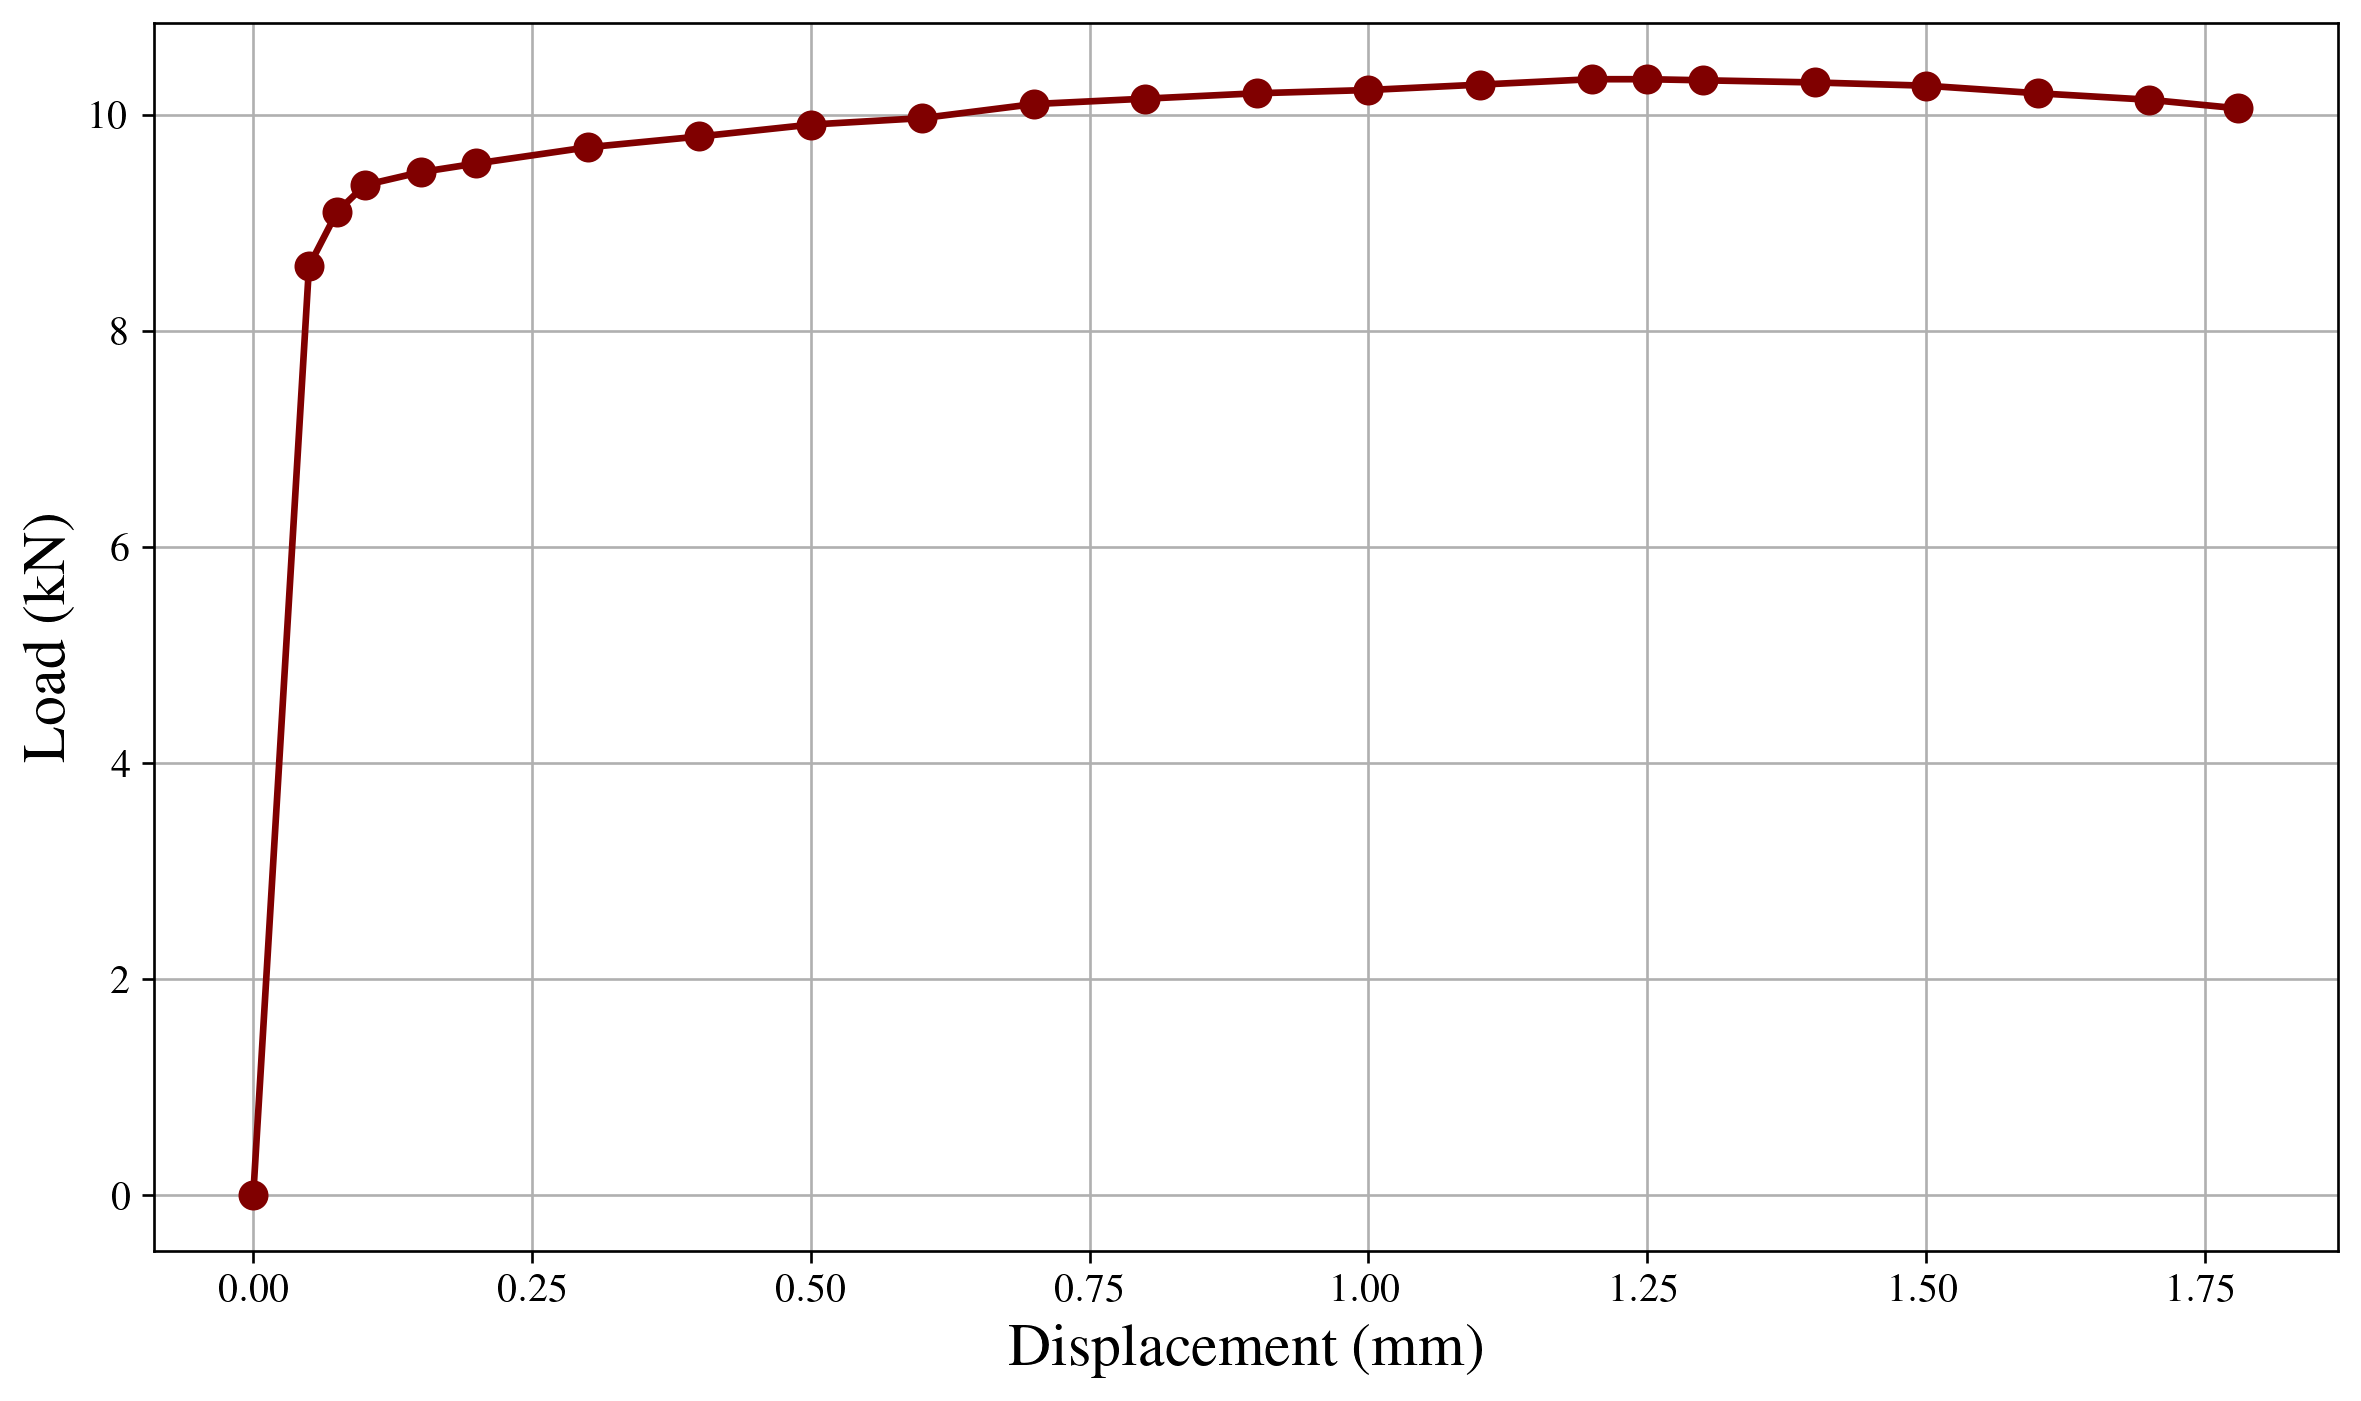

In [2]:
# Measurements
D = 6.3  # mm
L = 12.7  # mm
D_min = 4.2  # mm
R = 3.3  # mm

# Plotting Load vs Displacement
df = pd.read_csv('data.csv')  # data

fig, ax = plt.subplots()
ax.set_xlabel('Displacement (mm)')
ax.set_ylabel('Load (kN)')

ax.plot(df['Displacement'], df['Load']/1000, marker='o')
plt.show()

## Find
A) Obtain and superimpose plots of engineering and true stress-strain curves.
B) Determine the following monotonic tensile properties:

* Module of elasticity ($E$)
* Yield strength ($S_y$) at 0.2% offset
* Ultimate tensile strength ($S_u$)
* True fracture strength ($\sigma_f$)
* True fracture strain or ductility ($\epsilon_f$)
* Percent reduction in area ($\%RA$)

C) Determine the strength coefficient, $K$, and the strain hardening exponent, $n$.

## Solution
### Parts A and B
The relationship for engineering stress and strain is,

$$\sigma=\frac{F}{A}$$
$$\epsilon=\frac{\Delta L}{L}$$

The diameter and original length were determined to fully define the above relationships. True stress and strain are as follows:

$$\sigma_{true}=\sigma(\epsilon+1)$$
$$\epsilon_{true}=\ln(\epsilon+1)$$

The code cell below will generate a plot that highlights the key points from Part B.

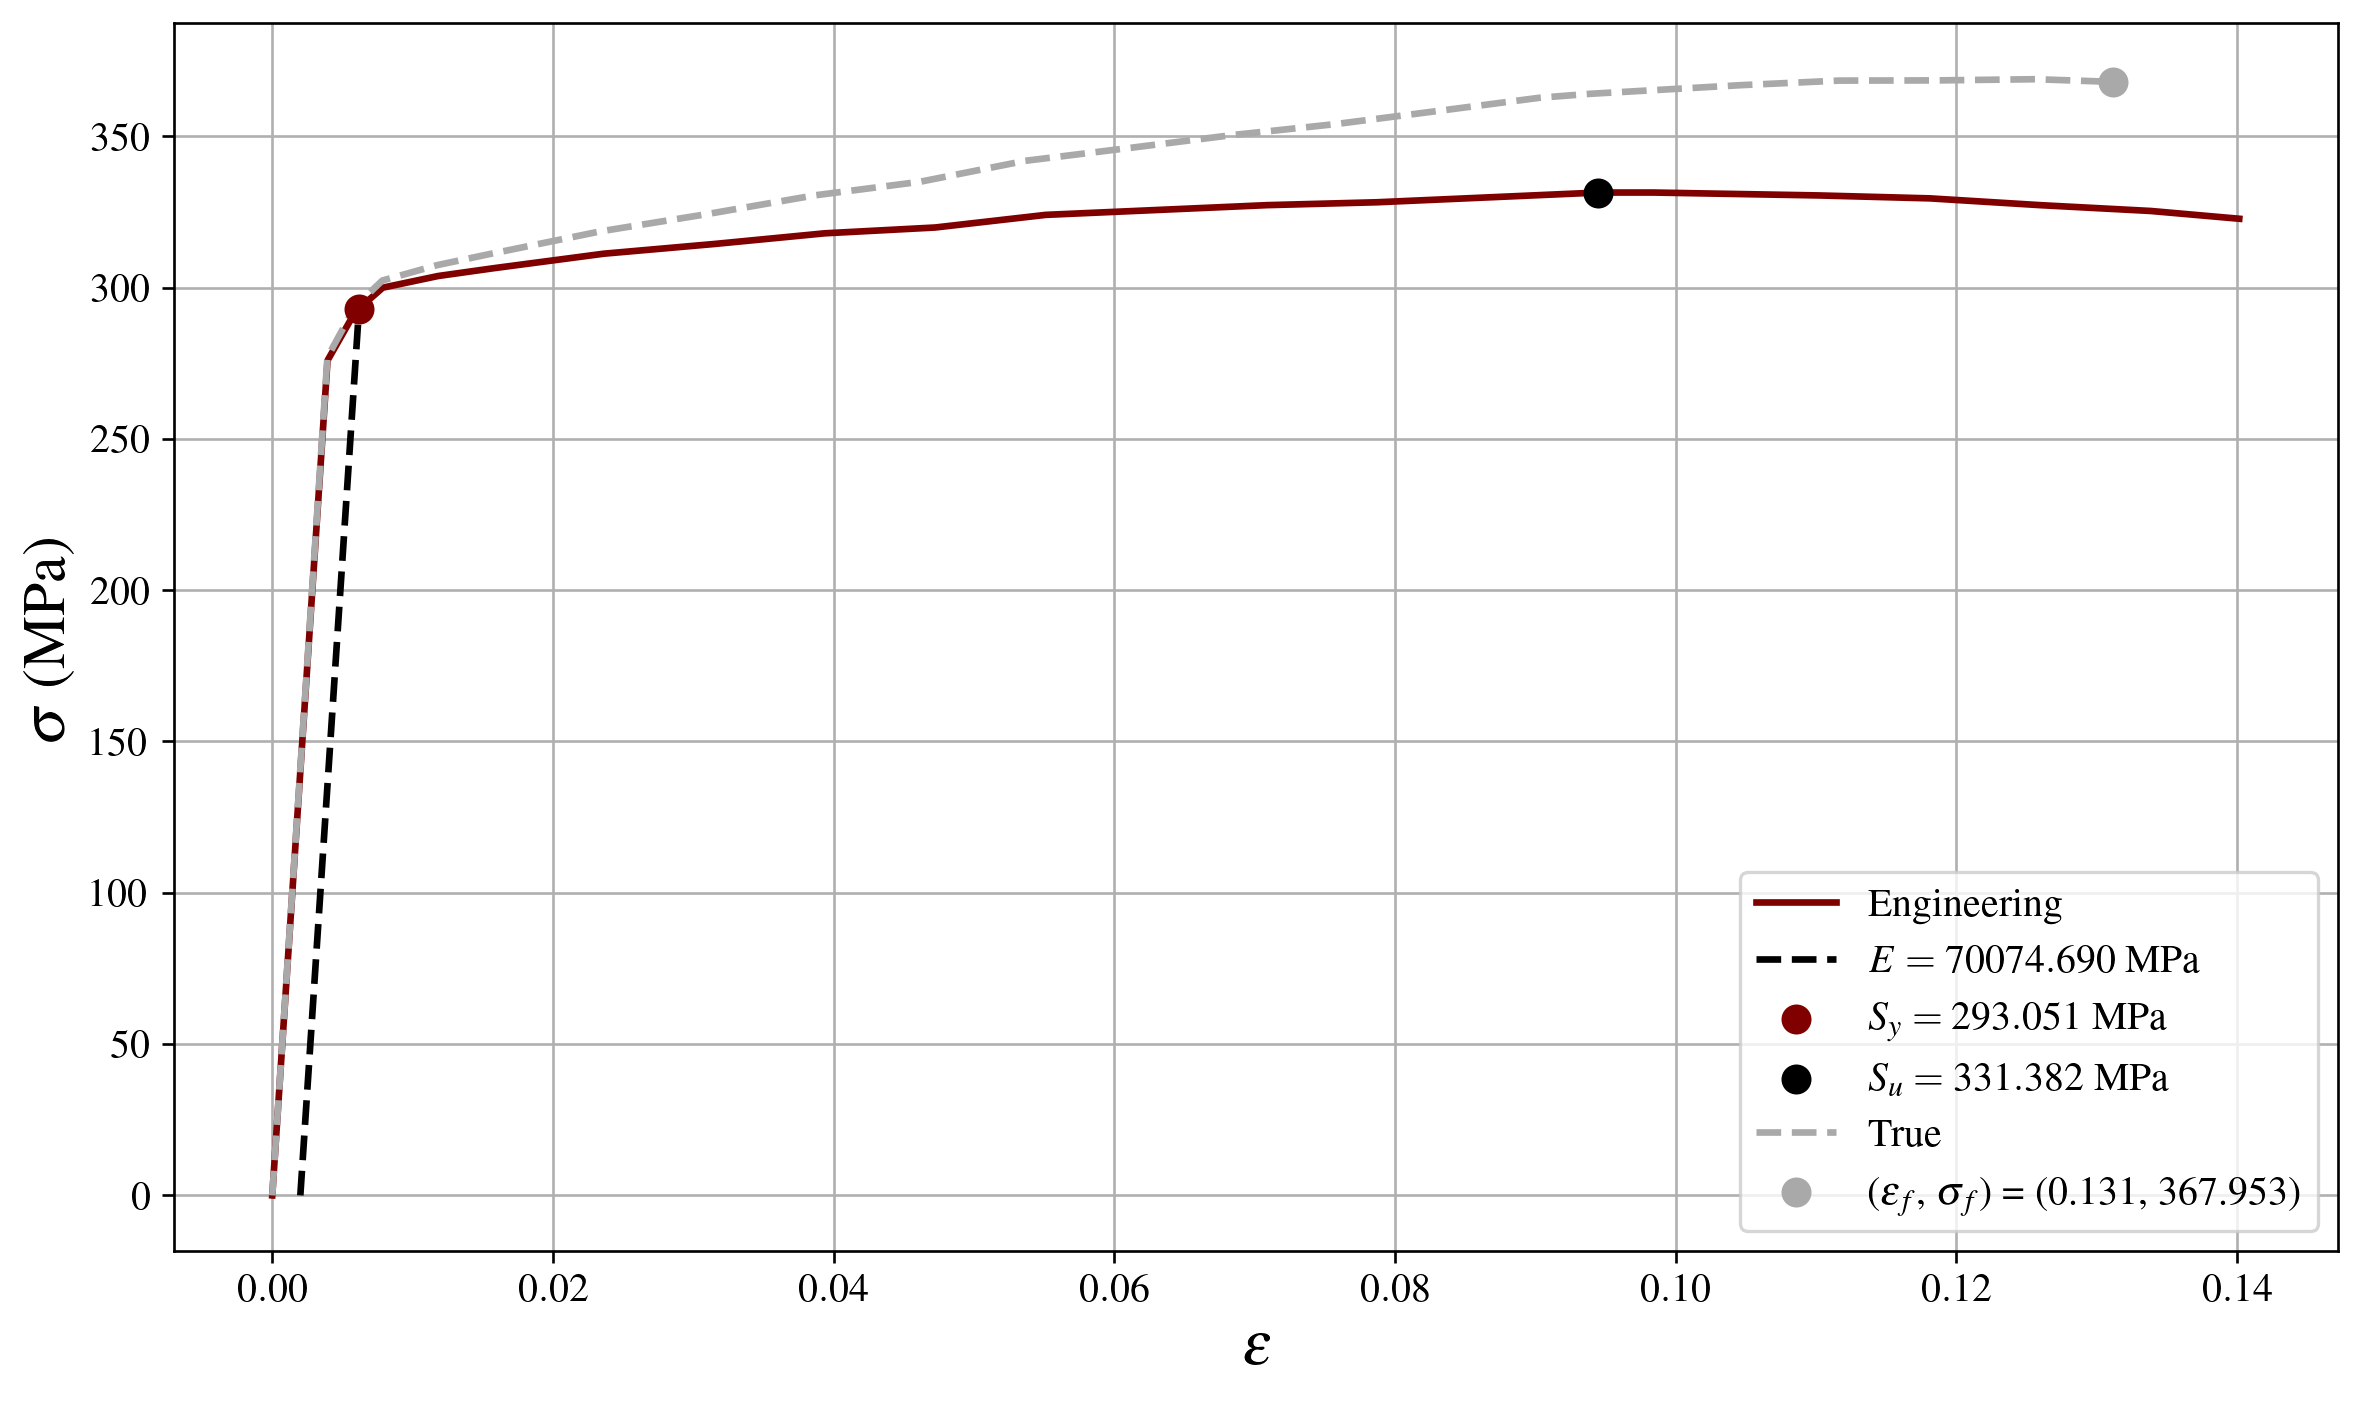

In [3]:
# Get stress and strain
A = np.pi/4*D**2
stress = np.array(df['Load']/A)
strain = np.array(df['Displacement']/L)

fig, ax = plt.subplots()
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$\sigma$ (MPa)')

ax.plot(strain, stress, label='Engineering', zorder=2)

# Get elastic modulus
# There appears to only be two points in the elastic region
E = (stress[1] - stress[0])/(strain[1] - strain[0])

# Find yield strength
f = interp1d(strain, stress, fill_value='extrapolate')
eps_y = fsolve(lambda x_: E*(x_ - 0.002) - f(x_), np.array([0.02, ]))[0]
Sy = f(eps_y)
ax.plot([0.002, eps_y], [0, Sy], ls='--', label=f'$E={E:.3f}$ MPa', zorder=2)
ax.scatter(eps_y, Sy, zorder=3, label=rf'$S_y={Sy:.3f}$ MPa')

# Find tensile strength
Su = np.max(stress)
ax.scatter(strain[stress == Su][0], Su, label=rf'$S_u={Su:.3f}$ MPa', zorder=3)

# Plot true stress and strain
true_stress = stress*(strain + 1)
true_strain = np.log(strain + 1)
ax.plot(true_strain, true_stress, label='True', zorder=2, ls='--')
sigma_f, epsilon_f = true_stress[-1], true_strain[-1]
ax.scatter(epsilon_f, sigma_f, label=rf'($\epsilon_f$, $\sigma_f$) = ({epsilon_f:.3f}, {sigma_f:.3f})', zorder=3)

ax.legend()
plt.show()

The true fracture stress and strain from the plot above does not apply to local fracture. The true fracture strain can be checked with the reduction of area calculation.

$$\epsilon_f=\ln\left(\frac{100}{100-\%RA}\right)$$

In [4]:
# Reduction of Area
Af = np.pi/4*D_min**2
RA = 100*(A - Af)/A
RA  # %

55.55555555555555

In [5]:
# Ductility
np.log(100/(100 - RA))

0.8109302162163285

The true fracture stress should be computed using the bridgman correction factor to compensate for the tri-axial state of stress, which applies to cylindrical specimens. The fracture force was reported to be 7.2 kN.

$$\sigma_f=\frac{P_f/A_f}{(1+4R/D_{min})\ln(1+D_{min}/4R)}$$

In [6]:
# True fracture stress
Pf = 7.2e3
Pf/Af/((1+4*R/D_min)*np.log(1+D_min/(4*R)))  # MPa

454.0842946770154

### Part C

The strength coefficient and hardening exponent is determined by curve fitting a straight line for a log-log plot of the plastic true stress and strain.

$$\sigma=K(\epsilon_p)^n$$

Only the data between the yield strength and ultimate strength is used to generate the curve below.

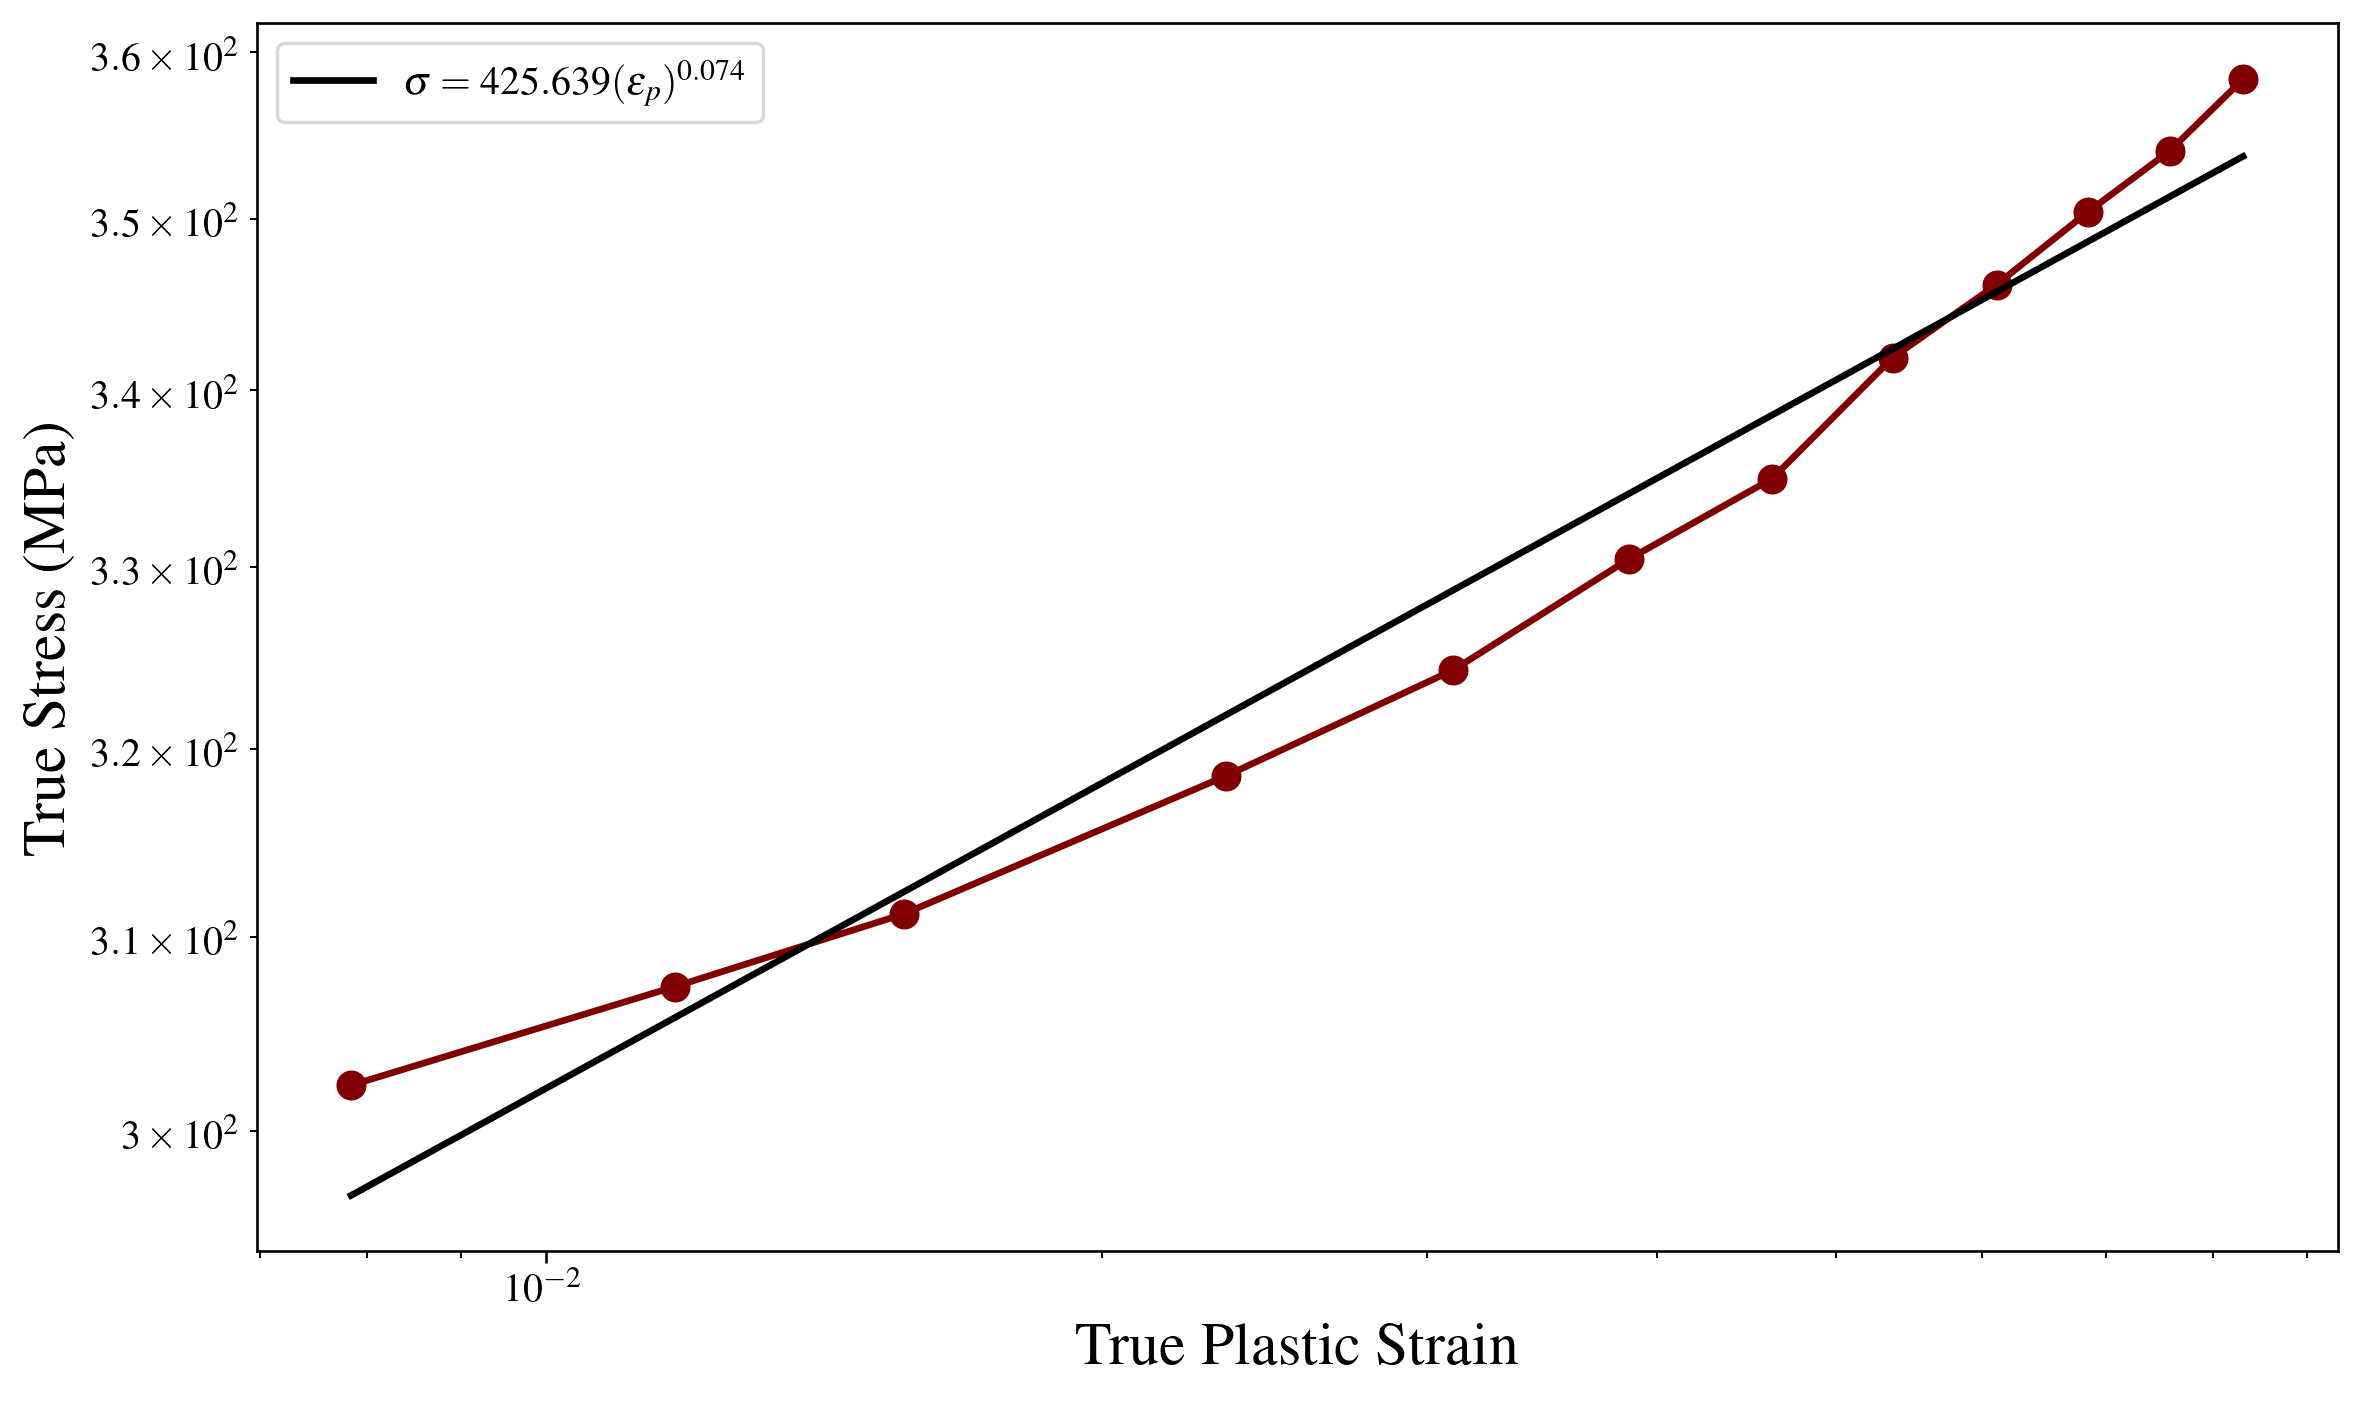

In [7]:
plastic = np.logical_and(stress > Sy, strain < strain[15])

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Plastic Strain')
ax.set_ylabel('True Stress (MPa)')
ax.grid(visible=False, which='both')

ax.plot(true_strain[plastic], true_stress[plastic], marker='o')

power_func = lambda x_, K_, n_: K_*x_**n_
popt, _ = curve_fit(power_func, true_strain[plastic], true_stress[plastic])
ax.plot(true_strain[plastic], power_func(true_strain[plastic], *popt), label=fr'$\sigma={popt[0]:.3f}(\epsilon_p)^{{{popt[1]:.3f}}}$')

ax.legend()
plt.show()

From the above plot, $K=426$ MPa and $n=0.074$.

\pagebreak

\begin{center}
\begin{tabular}{ccc}
ME 8253 & Homework 3 & Gabe Morris \\
& & gnm54
\end{tabular}
\end{center}

#
## Given

\begin{center}
\includegraphics{images/Figure 1}
\end{center}

In [8]:
sig_prime = 1043  # MPa
E = 201e3  # MPa
eps_prime = 0.309
b, c = -0.107, -0.481

## Find
A) Superimpose plots of elastic, plastic, and total strain versus life curves
B) Determine the total, elastic, and plastic strain amplitudes for smooth uni-axial test specimens for life to:

* $10^3$ cycles ($2\cdot10^3$ reversals)
* $10^5$ cycles ($2\cdot10^5$ reversals)

C) Repeat Part B using the equation of the Method of Universal Slopes below and comment on any differences from Part B.

$$\frac{\Delta \epsilon}{2}=\frac{\Delta \epsilon_e}{2}+\frac{\Delta \epsilon_p}{2}=0.623\left(\frac{S_u}{E}\right)^{0.832}\left(2 N_f\right)^{-0.09}+0.0196\left(\epsilon_f\right)^{0.155}\left(\frac{S_u}{E}\right)^{-0.53}\left(2 N_f\right)^{-0.56}$$

D) If the mean stress is $\sigma_m=0.2\sigma^\prime_f$, what approximate effect does this have on 1038 steel strain amplitude for $10^3$ and $10^5$ cycles using the three mean stress equations:

* Morrow's parameter:

$$\frac{\Delta \epsilon}{2}=\epsilon_a=\frac{\sigma_f^{\prime}-\sigma_m}{E}\left(2 N_f\right)^b+\epsilon_f^{\prime}\left(2 N_f\right)^c$$

* Alternative version of Morrow's mean stress parameter:

$$\frac{\Delta \epsilon}{2}=\epsilon_a=\frac{\sigma_f^{\prime}-\sigma_m}{E}\left(2 N_f\right)^b+\epsilon_f^{\prime}\left(\frac{\sigma_f^{\prime}-\sigma_m}{\sigma_f^{\prime}}\right)^{\frac{c}{b}}\left(2 N_f\right)^c$$

* Smith, Watson, and Topper (SWT parameter):

$$\sigma_{\max } \epsilon_a E=\left(\sigma_f^{\prime}\right)^2\left(2 N_f\right)^{2 b}+\sigma_f^{\prime} \epsilon_f^{\prime} E\left(2 N_f\right)^{b+c}$$

where $\sigma_{max}=\sigma_m+\sigma_a$ and $\epsilon_a$ is the alternating strain (strain amplitude)

Note: In the SWT parameter case, the stress amplitude $\sigma_a$ and the strain amplitude $\epsilon_a$ are found solving both the SWT nonlinear equation and the following Ramberg-Osgood nonlinear equation:

$$\epsilon_a=\frac{\sigma_a}{E}+\left(\frac{\sigma_a}{K^{\prime}}\right)^{1 / n^{\prime}}$$

E) Compare the results of Part D with those of Part B. Where does $\sigma_m$ have its greatest influence?

## Solution
For elastic behavior, the Basquin equation is used:

$$\frac{\Delta\sigma}{2}=\sigma^\prime_f(2N_f)^b\rightarrow\frac{\Delta\epsilon_e}{2}=\frac{\sigma^\prime_f}{E}(2N_f)^b$$

For plastic behavior, the Manson-Coffin relationship is used:

$$\frac{\Delta\epsilon_p}{2}=\epsilon^\prime_f(2N_f)^c$$

The total strain amplitude is the sum of the above relationships:

$$\epsilon_a=\frac{\Delta\epsilon_e}{2}+\frac{\Delta\epsilon_p}{2}=\frac{\sigma^\prime_f}{E}(2N_f)^b+\epsilon^\prime_f(2N_f)^c$$

### Part A

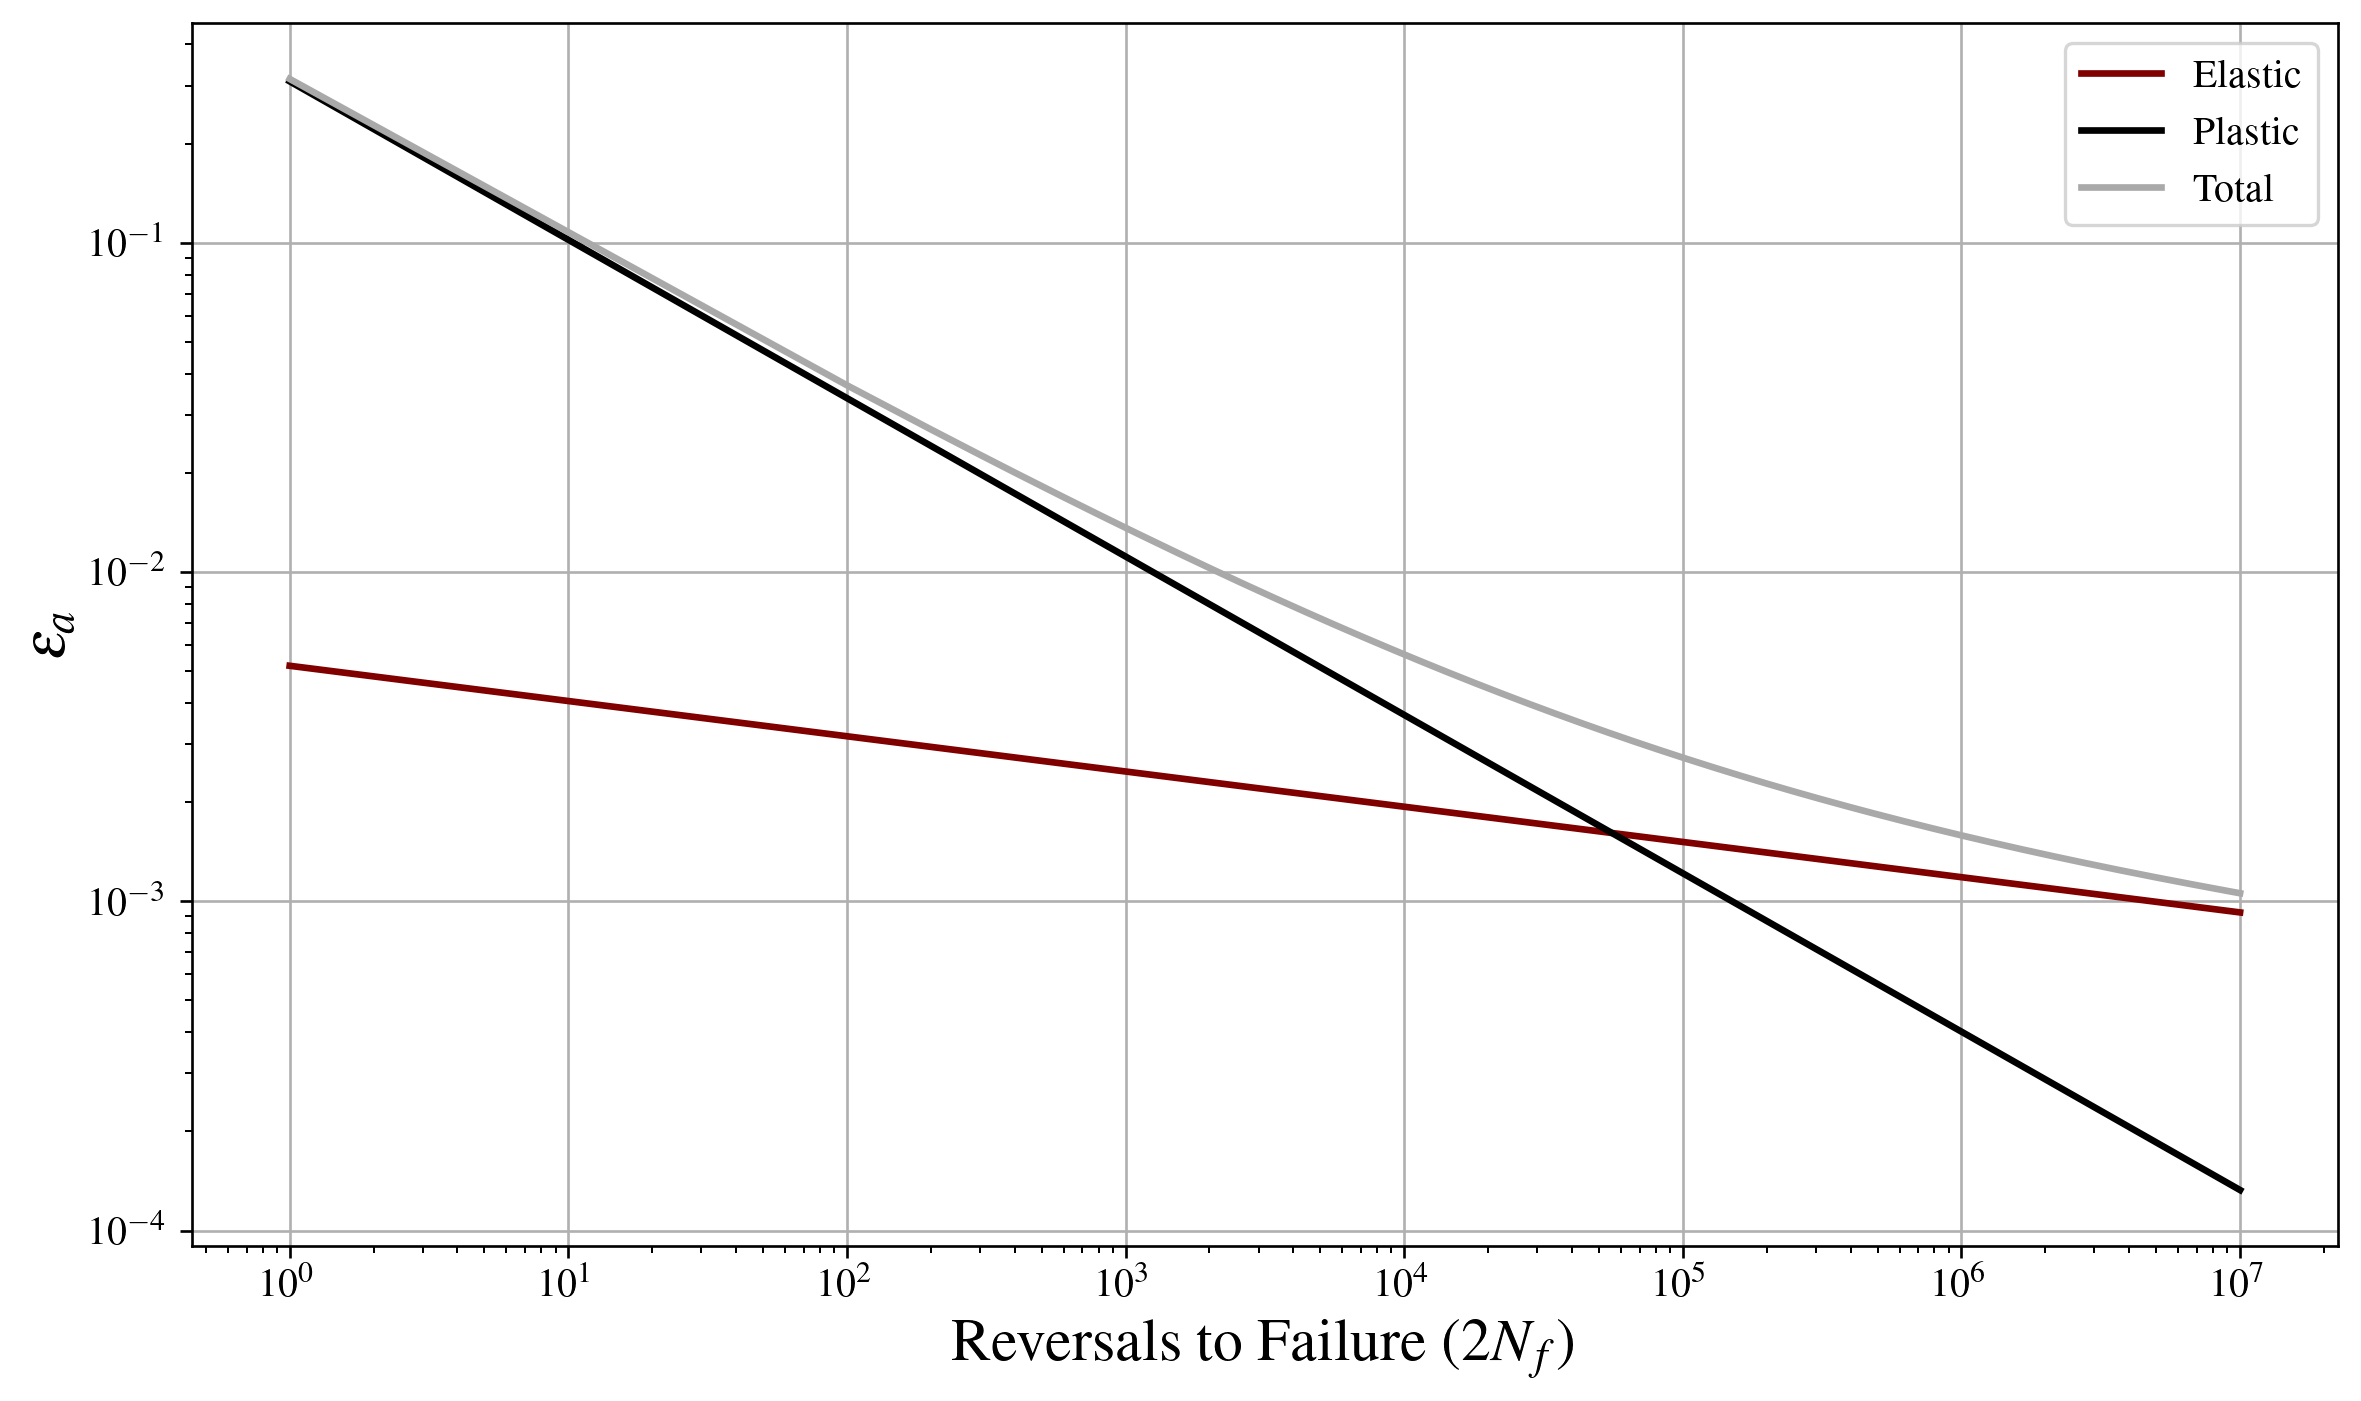

In [9]:
# Elastic function
eps_elastic = lambda Nt_: sig_prime/E*Nt_**b

# Plastic function
eps_plastic = lambda Nt_: eps_prime*Nt_**c

# Total
eps_total = lambda Nt_: eps_elastic(Nt_) + eps_plastic(Nt_)

# Making plot
Nt = np.linspace(1, 1e7, 100_000)  # number of reversals
fig, ax = plt.subplots()
ax.set_xlabel('Reversals to Failure ($2N_f$)')
ax.set_ylabel(r'$\epsilon_a$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(Nt, eps_elastic(Nt), label='Elastic')
ax.plot(Nt, eps_plastic(Nt), label='Plastic')
ax.plot(Nt, eps_total(Nt), label='Total')

ax.legend()
plt.show()

### Part B
The functions created above can be simply reused. The number of reversals is used for the strain life models.

**1000 Cycles**

In [10]:
# Elastic strain
eps_elastic(2e3)

0.0023007956175003924

In [11]:
# Plastic strain
eps_plastic(2e3)

0.007982943426230897

In [12]:
# Total strain
B_3 = eps_total(2e3)
B_3

0.01028373904373129

**100,000 Cycles**

In [13]:
# Elastic strain
eps_elastic(2e5)

0.001405652733449556

In [14]:
# Plastic strain
eps_plastic(2e5)

0.000871290645897684

In [15]:
# Total strain
B_5 = eps_total(2e5)
B_5

0.00227694337934724

### Part C
The Universal Slopes method can be used to compare the total strain from Part A. The only additional parameter is the ductility ($\epsilon_f=0.77$) and the tensile strength ($S_u=582$ MPa).

**1000 Cycles**

In [16]:
Su = 582  # MPa
eps_f = 0.77
0.623*(Su/E)**0.832*2e3**-0.09 + 0.0196*eps_f**0.155*(Su/E)**-0.53*2e3**-0.56

0.008336739266295948

**100,000 Cycles**

In [17]:
0.623*(Su/E)**0.832*2e5**-0.09 + 0.0196*eps_f**0.155*(Su/E)**-0.53*2e5**-0.56

0.002053379976480394

For 1,000 cycles, the value from Part B is 23.4% greater. For 100,000 cycles, the value from Part B is 10.9% greater; therefore, the Universal Slopes method can be considered as not conservative and should be avoided for this case.

### Part D
**Morrow's Parameter**

$$\frac{\Delta \epsilon}{2}=\epsilon_a=\frac{\sigma_f^{\prime}-\sigma_m}{E}\left(2 N_f\right)^b+\epsilon_f^{\prime}\left(2 N_f\right)^c$$

**1,000 Cycles**

In [18]:
sig_mean = 0.2*sig_prime

D_M3 = (sig_prime - sig_mean)/E*2e3**b + eps_prime*2e3**c
D_M3

0.009823579920231211

**100,000 Cycles**

In [19]:
D_M5 = (sig_prime - sig_mean)/E*2e5**b + eps_prime*2e5**c
D_M5

0.0019958128326573285

**Alternative Morrow's Parameter**

$$\frac{\Delta \epsilon}{2}=\epsilon_a=\frac{\sigma_f^{\prime}-\sigma_m}{E}\left(2 N_f\right)^b+\epsilon_f^{\prime}\left(\frac{\sigma_f^{\prime}-\sigma_m}{\sigma_f^{\prime}}\right)^{\frac{c}{b}}\left(2 N_f\right)^c$$

**1,000 Cycles**

In [20]:
D_AM3 = (sig_prime - sig_mean)/E*2e3**b + eps_prime*((sig_prime - sig_mean)/sig_prime)**(c/b)*2e3**c
D_AM3

0.004768297871995594

**100,000 Cycles**

In [21]:
D_AM5 = (sig_prime - sig_mean)/E*2e5**b + eps_prime*((sig_prime - sig_mean)/sig_prime)**(c/b)*2e5**c
D_AM5

0.0014440589587003646

**Smith, Watson, and Topper Parameter**

$$\sigma_{\max } \epsilon_a E=\left(\sigma_f^{\prime}\right)^2\left(2 N_f\right)^{2 b}+\sigma_f^{\prime} \epsilon_f^{\prime} E\left(2 N_f\right)^{b+c}$$

$$\epsilon_a=\frac{\sigma_a}{E}+\left(\frac{\sigma_a}{K^\prime}\right)^{1/n^\prime}$$

$$\sigma_{max}=\sigma_m+\sigma_a$$

Although `fsolve` may be used as a numerical solver, `sympy` also has a numerical solver and is able to clearly show the equations through \LaTeX. There are three equations and three unknowns ($\sigma_{max}$, $\sigma_a$, and $\epsilon_a$).

**1,000 Cycles**

In [22]:
# Define symbols
sig_max_, eps_a_, E_ = sp.symbols(r'\sigma_{max} \epsilon_a E')
sig_prime_, Nr_, b_, c_, eps_prime_ = sp.symbols(r'\sigma^`_f N_t b c \epsilon^`_f')
K_prime_, n_prime_, sig_m_, sig_a_ = sp.symbols(r'K^` n^` \sigma_m \sigma_a')

eq1 = sp.Eq(sig_max_*eps_a_*E_, sig_prime_**2*Nr_**(2*b_) + sig_prime_*eps_prime_*E_*Nr_**(b_ + c_))
eq2 = sp.Eq(eps_a_, sig_a_/E_ + (sig_a_/K_prime_)**(1/n_prime_))
eq3 = sp.Eq(sig_max_, sig_m_ + sig_a_)
display(eq1, eq2, eq3)

display(Markdown('---'))
subs3 = [(sig_prime_, sig_prime), (sig_m_, sig_mean), (eps_prime_, eps_prime), (E_, E), (Nr_, 2e3), (b_, b), (c_, c), (K_prime_, 1340), (n_prime_, sp.S('0.22'))]

with sp.evaluate(False):
    eq1_ = sp.Eq(eq1.lhs.subs(subs3), eq1.rhs.subs(subs3))
    eq2_ = sp.Eq(eq2.lhs.subs(subs3), eq2.rhs.subs(subs3))
    eq3_ = sp.Eq(eq3.lhs.subs(subs3), eq3.rhs.subs(subs3))
display(eq1_, eq2_, eq3_)

Eq(E*\epsilon_a*\sigma_{max}, E*N_t**(b + c)*\epsilon^`_f*\sigma^`_f + N_t**(2*b)*\sigma^`_f**2)

Eq(\epsilon_a, (\sigma_a/K^`)**(1/n^`) + \sigma_a/E)

Eq(\sigma_{max}, \sigma_a + \sigma_m)

---

Eq(201000.0*\epsilon_a*\sigma_{max}, 2000.0**(2*(-0.107))*1043**2 + 201000.0*0.309*1043*2000.0**(-0.481 - 0.107))

Eq(\epsilon_a, \sigma_a/201000.0 + (\sigma_a/1340)**(1/0.22))

Eq(\sigma_{max}, \sigma_a + 208.6)

In [23]:
# Solve the system
sol = sp.nsolve([eq1_, eq2_, eq3_], [eps_a_, sig_a_, sig_max_], [0.1, 100, 100], dict=True)[0]
for key, value in sol.items():
    display(sp.Eq(key, sp.re(value)))

D_SMT3 = float(sp.re(sol[eps_a_]))

Eq(\epsilon_a, 0.00750877406155887)

Eq(\sigma_a, 424.767988888844)

Eq(\sigma_{max}, 633.367988888844)

**100,000 Cycles**

In [24]:
subs5 = [(sig_prime_, sig_prime), (sig_m_, sig_mean), (eps_prime_, eps_prime), (E_, E), (Nr_, 2e5), (b_, b), (c_, c), (K_prime_, 1340), (n_prime_, sp.S('0.22'))]

with sp.evaluate(False):
    eq1_ = sp.Eq(eq1.lhs.subs(subs5), eq1.rhs.subs(subs5))
    eq2_ = sp.Eq(eq2.lhs.subs(subs5), eq2.rhs.subs(subs5))
    eq3_ = sp.Eq(eq3.lhs.subs(subs5), eq3.rhs.subs(subs5))
display(eq1_, eq2_, eq3_)

Eq(201000.0*\epsilon_a*\sigma_{max}, 201000.0*0.309*1043*200000.0**(-0.481 - 0.107) + 200000.0**(2*(-0.107))*1043**2)

Eq(\epsilon_a, \sigma_a/201000.0 + (\sigma_a/1340)**(1/0.22))

Eq(\sigma_{max}, \sigma_a + 208.6)

In [25]:
# Solve the system
sol = sp.nsolve([eq1_, eq2_, eq3_], [eps_a_, sig_a_, sig_max_], [0.01, 200, 300], dict=True)[0]
for key, value in sol.items():
    display(sp.Eq(key, sp.re(value)))

D_SMT5 = float(sp.re(sol[eps_a_]))

Eq(\epsilon_a, 0.00146888148497975)

Eq(\sigma_a, 229.365169607826)

Eq(\sigma_{max}, 437.965169607826)

### Part E

The table below shows a summary of the different methods for obtaining the stress amplitude. The percent difference is relative to the reversible case in which the mean stress is zero.

In [26]:
df = pd.DataFrame(data={
    '1,000 Cycles': [B_3, D_M3, D_AM3, D_SMT3],
    '\% Difference at 1,000': [0, (B_3 - D_M3)/D_M3*100, (B_3 - D_AM3)/D_AM3*100, (B_3 - D_SMT3)/D_SMT3*100],
    '100,000 Cycles': [B_5, D_M5, D_AM5, D_SMT5],
    '\% Difference at 100,000': [0, (B_5 - D_M5)/D_M5*100, (B_5 - D_AM5)/D_AM5*100, (B_5 - D_SMT5)/D_SMT5*100]
}, index=['Reversible', 'Morrow', 'Alternative Morrow', 'SWT'])
df_style = df.style.to_latex(hrules=True)
display(Latex(df_style))

<IPython.core.display.Latex object>

The overall effect of having a mean stress other than zero is that the strain amplitude must be decreased to have the same number of cycles as a fully reversible case. The Alternative Morrow method, however, is the most conservative of the three options above with having lower values of the strain amplitude compared to the others. The original Morrow method is the least conservative with changes that are less than the other two.